In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode

# Đọc dữ liệu

df = pd.read_csv(r'C:\Users\Pham Thanh\Downloads\Timesseries\Cholera.csv')

# Tiền xử lý
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.date
daily_counts = df.groupby('day').size().reset_index(name='count')
daily_counts['month'] = pd.to_datetime(daily_counts['day']).dt.to_period('M')
monthly_total = daily_counts.groupby('month')['count'].transform('sum')
daily_counts['ratio'] = daily_counts['count'] / monthly_total

def classify_ratio(r):
    if r < 0.01: return 0
    elif r < 0.03: return 1
    else: return 2

daily_counts['label'] = daily_counts['ratio'].apply(classify_ratio)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
daily_counts['count_scaled'] = scaler.fit_transform(daily_counts[['count']])

# Tạo chuỗi thời gian
window_size = 30
horizon = 7

X, y = [], []
for i in range(len(daily_counts) - window_size - horizon):
    X.append(daily_counts['count_scaled'].values[i:i+window_size])
    future_labels = daily_counts['label'].values[i+window_size:i+window_size+horizon]

    mode_result = mode(future_labels, keepdims=True)
    if mode_result.mode.size > 0:
        y.append(mode_result.mode[0])
    else:
        y.append(future_labels[0])  # fallback


X = np.array(X)[..., np.newaxis]  # (samples, 30, 1)
y = np.array(y)  # (samples,)
daily_counts

,day,count,month,ratio,label,count_scaled
0,2007-01-19,1,2007-01,1.000000,2,-0.853706
1,2007-02-25,1,2007-02,1.000000,2,-0.853706
2,2007-03-13,1,2007-03,1.000000,2,-0.853706
3,2007-04-12,2,2007-04,0.500000,2,-0.851997
4,2007-04-26,1,2007-04,0.250000,2,-0.853706
...,...,...,...,...,...,...
4634,2020-06-15,1387,2020-06,0.066048,2,1.515050
4635,2020-06-16,1548,2020-06,0.073714,2,1.790208
4636,2020-06-17,1412,2020-06,0.067238,2,1.557776
4637,2020-06-18,1204,2020-06,0.057333,2,1.202292


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
# Tạo Dataset và DataLoader
dataset = TimeSeriesDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [3]:
import torch.nn as nn
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.layer = nn.TransformerEncoderLayer(d_model, n_heads, d_ff, batch_first=True)

    def forward(self, x):
        return self.layer(x)
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.layer = nn.TransformerDecoderLayer(d_model, n_heads, d_ff, batch_first=True)

    def forward(self, tgt, memory):
        return self.layer(tgt, memory)


In [4]:
class InformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, d_ff, n_layers, pred_len, n_classes):
        super().__init__()
        self.pred_len = pred_len

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)
        ])

        self.decoder_input = nn.Parameter(torch.zeros(1, pred_len, d_model))
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)
        ])

        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, x):
        # x: (B, seq_len, input_dim)
        x = self.input_proj(x)  # (B, seq_len, d_model)
        x = self.pos_enc(x)

        # Encoder
        for layer in self.encoder_layers:
            x = layer(x)
        memory = x

        # Decoder (dự báo pred_len bước tương lai)
        dec_in = self.decoder_input.repeat(x.size(0), 1, 1)  # (B, pred_len, d_model)
        for layer in self.decoder_layers:
            dec_in = layer(dec_in, memory)

        out = dec_in.mean(dim=1)  # Lấy đặc trưng trung bình của pred_len bước
        return self.classifier(out)  # (B, n_classes)


In [5]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import torch

def train_model(model, train_loader, num_epochs=20, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    acc_list, f1_list, loss_list = [], [], []

    for epoch in range(num_epochs):
        model.train()
        y_true, y_pred = [], []
        total_loss = 0.0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = output.argmax(dim=1)
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')

        acc_list.append(acc)
        f1_list.append(f1)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}")

    # In kết quả cuối cùng
    print(f"\nFinal Accuracy: {acc_list[-1]:.4f}")
    print(f"Final F1 Score: {f1_list[-1]:.4f}")
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=2))

    # Vẽ biểu đồ loss
    plt.figure(figsize=(8, 4))
    plt.plot(loss_list, label='Loss', color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    return acc_list[-1], f1_list[-1]


Epoch 1: Loss=0.7281
Epoch 2: Loss=0.6918
Epoch 3: Loss=0.6896
Epoch 4: Loss=0.6808
Epoch 5: Loss=0.6779
Epoch 6: Loss=0.6735
Epoch 7: Loss=0.6622
Epoch 8: Loss=0.6550
Epoch 9: Loss=0.6487
Epoch 10: Loss=0.6496
Epoch 11: Loss=0.6457
Epoch 12: Loss=0.6362
Epoch 13: Loss=0.6385
Epoch 14: Loss=0.6323
Epoch 15: Loss=0.6368
Epoch 16: Loss=0.6315
Epoch 17: Loss=0.6300
Epoch 18: Loss=0.6215
Epoch 19: Loss=0.6317
Epoch 20: Loss=0.6304
Epoch 21: Loss=0.6298
Epoch 22: Loss=0.6234
Epoch 23: Loss=0.6299
Epoch 24: Loss=0.6192
Epoch 25: Loss=0.6237
Epoch 26: Loss=0.6248
Epoch 27: Loss=0.6231
Epoch 28: Loss=0.6145
Epoch 29: Loss=0.6157
Epoch 30: Loss=0.6176
Epoch 31: Loss=0.6151
Epoch 32: Loss=0.6110
Epoch 33: Loss=0.6118
Epoch 34: Loss=0.6143
Epoch 35: Loss=0.6028
Epoch 36: Loss=0.6044
Epoch 37: Loss=0.6062
Epoch 38: Loss=0.6082
Epoch 39: Loss=0.6006
Epoch 40: Loss=0.6049
Epoch 41: Loss=0.5964
Epoch 42: Loss=0.5975
Epoch 43: Loss=0.6008
Epoch 44: Loss=0.5936
Epoch 45: Loss=0.5929
Epoch 46: Loss=0.59

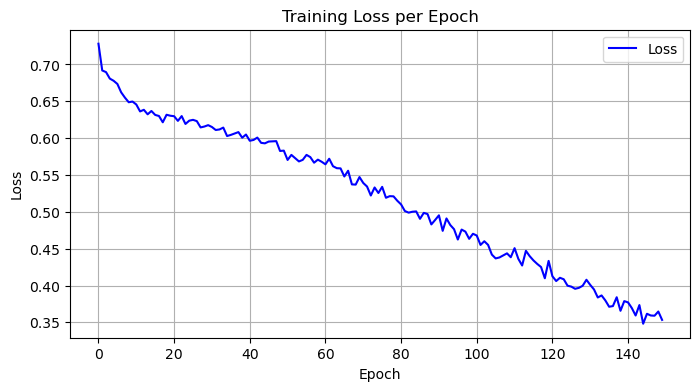

In [6]:
model = InformerClassifier(input_dim=1, d_model=64, n_heads=4, d_ff=128, n_layers=2, pred_len=30, n_classes=3)
accuracy, f1 = train_model(model, train_loader, num_epochs=150)

In [7]:
#torch.save(model.state_dict(), 'informer_classifier.pt')
#print("Model saved to informer_classifier.pt")


Model saved to informer_classifier.pt


In [8]:
# Khởi tạo lại mô hình giống hệt kiến trúc lúc huấn luyện
#model = InformerClassifier(input_dim=1, d_model=64, n_heads=4, d_ff=128, n_layers=2, pred_len=30, n_classes=3)
#model.load_state_dict(torch.load('informer_classifier.pt'))
#model.eval()  # chuyển sang chế độ dự đoán


InformerClassifier(
  (input_proj): Linear(in_features=1, out_features=64, bias=True)
  (pos_enc): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-1): 2 x EncoderLayer(
      (layer): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder_layers): ModuleList(
    (0-1): 2 x DecoderLayer(
      (layer): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQua